# Predicting Survival on the Titanic with Machine Learning 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andrianllmm/ds100-ws2/blob/main/notebooks/notebook.ipynb)
[![View on GitHub](https://img.shields.io/badge/View%20on-GitHub-black?logo=github)](https://github.com/andrianllmm/ds100-ws2/blob/main/notebooks/notebook.ipynb)

## Introduction

<!-- Image -->
<img src="https://raw.githubusercontent.com/andrianllmm/ds100-ws2/main/images/intro.jpg" width="40%">

This notebook explores the *Titanic* passenger dataset to predict survival using machine learning. We will perform:
- Exploratory Data Analysis (EDA)
- Feature Engineering
- Data Preprocessing
- Model Training (with Logistic Regression & Random Forest)
- Model Evaluation
- Insights and reflections

## Setup

In [1140]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re

# Scikit-learn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedGroupKFold 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Display settings
%matplotlib inline

In [1141]:
# Load data
url_to_data = "https://raw.githubusercontent.com/andrianllmm/ds100-ws2/main/data/train.csv"
local_path_to_data = "../data/train.csv"
df = pd.read_csv(local_path_to_data, index_col='PassengerId')

# Quick peek
print(df.shape)
df.head()

(891, 11)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploratory Data Analysis (EDA)

*1. Perform basic EDA.*

There are **891** passengers with 12 features. Each feature has the correct type. Some features have missing values (Age, Cabin, Embarked).

In [1142]:
# Basic info
df.info()
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Approximately 38% of the passengers survived, 62% did not.

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


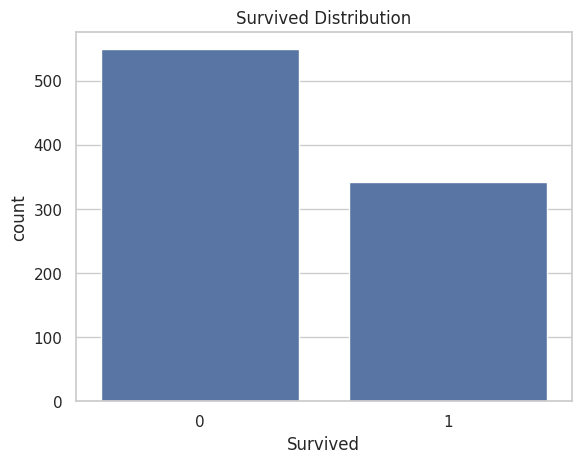

In [1143]:
# % of people who survived
print(df['Survived'].value_counts(normalize=True)) 

# Target distribution
sns.countplot(x='Survived', data=df)
plt.title('Survived Distribution')
plt.show()

1st-class passengers had the highest survival rates, followed by 2nd-class. 3rd-class had the lowest survival.

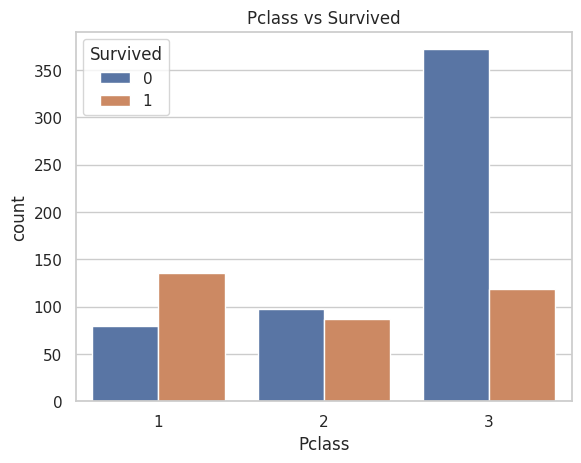

In [1144]:
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title('Pclass vs Survived')
plt.show()

Females survived at a much higher rate than males.

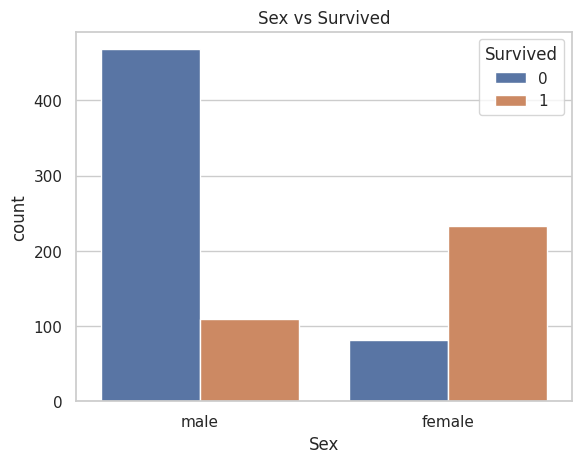

In [1145]:
sns.countplot(x='Sex', hue='Survived', data=df)
plt.title('Sex vs Survived')
plt.show()

Younger passengers had slightly higher chances of survival.

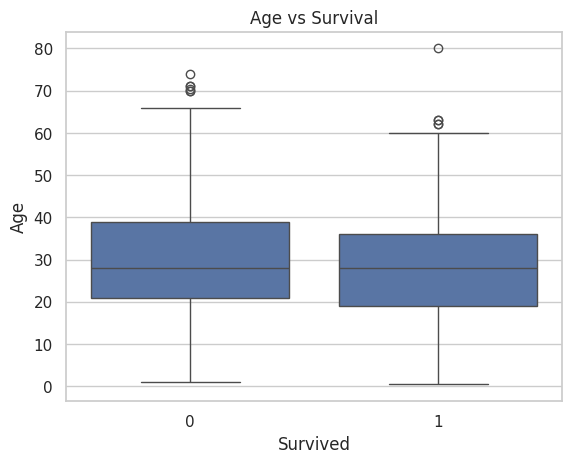

In [1146]:
sns.boxplot(x='Survived', y='Age', data=df)
plt.title('Age vs Survival')
plt.xlabel('Survived')
plt.ylabel('Age')
plt.show()

Passengers who paid higher fares (likely in 1st class) teded to have higher survival rates.

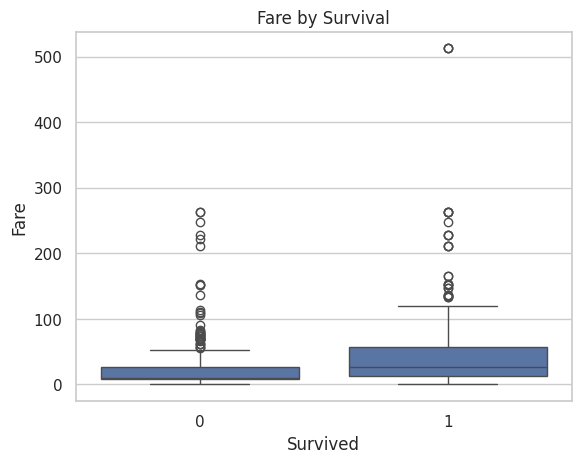

In [1147]:
sns.boxplot(x='Survived', y='Fare', data=df)
plt.title('Fare by Survival')
plt.show()

## Feature Engineering *(Optional)*

Feature engineering is the creation of additional features (columns) in our dataset typically derived from other columns. This step is not in the spec but can be helpful in making seemingly useless features more useful, and thus making our predictions more accurate.

### Titles From Names

The names of the passengers by themselves are not really helpful in predicting survival. However, the names listed have titles in them (such as Mr, Mrs, Miss, Master) which can be helpful categorical data.

In [1148]:
# Create Title from Name
def extract_title(name):
    m = re.search(r",\s*([^\.]+)\.", name)
    return m.group(1).strip() if m else 'Unknown'

df['Title'] = df['Name'].apply(extract_title)

# Group rare titles
rare_titles = (df['Title'].value_counts() < 10)
df['Title'] = df['Title'].apply(lambda t: 'Rare' if rare_titles.get(t, False) else t)

rare_titles_removed = list(rare_titles[rare_titles].index)
print("Rare titles removed: ", rare_titles_removed)
df['Title'].value_counts()

Rare titles removed:  ['Dr', 'Rev', 'Col', 'Mlle', 'Major', 'Ms', 'Mme', 'Don', 'Lady', 'Sir', 'Capt', 'the Countess', 'Jonkheer']


Title
Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: count, dtype: int64

As we can see, titles can be a good predictor of survival.

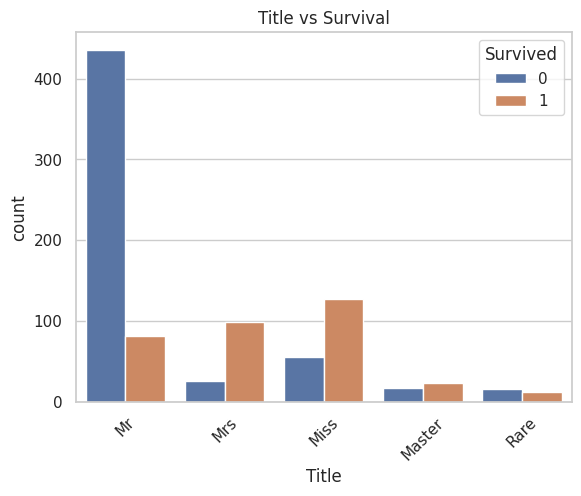

In [1149]:
sns.countplot(x='Title', hue='Survived', data=df)
plt.title('Title vs Survival')
plt.xticks(rotation=45)
plt.show()

### Family

Sibling, spouse, parent, and children columns seem pretty helpful but their current format is not ideal. We can make them more helpful by counting the total family size instead and 

In [1150]:
# Family size and alone or not
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

As we can see, those with slight bigger family (around 2 to 4 relatives) had higher chances of survival. Passengers who were alone were also more likely to not survive.

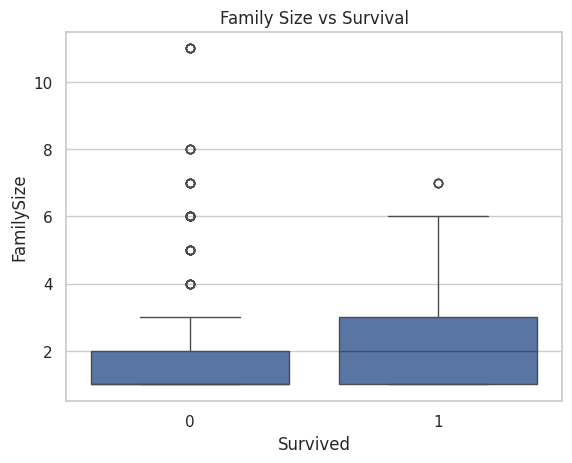

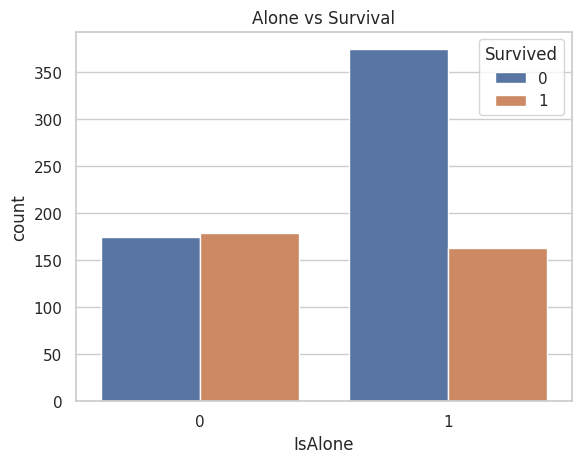

In [1151]:
# Family size
sns.boxplot(x='Survived', y='FamilySize', data=df)
plt.title('Family Size vs Survival')
plt.show()

# Alone or not
sns.countplot(x='IsAlone', hue='Survived', data=df)
plt.title('Alone vs Survival')
plt.show()

### Deck from Cabin

The cabin of the passengers are currently too specific. We can make it more general by extracting the deck instead. We do this by getting the first letter.

In [1152]:
# Extract deck from Cabin (first letter)
df['Deck'] = df['Cabin'].str[0]

As we can see, the deck of the passenger can be an indicator of survival.

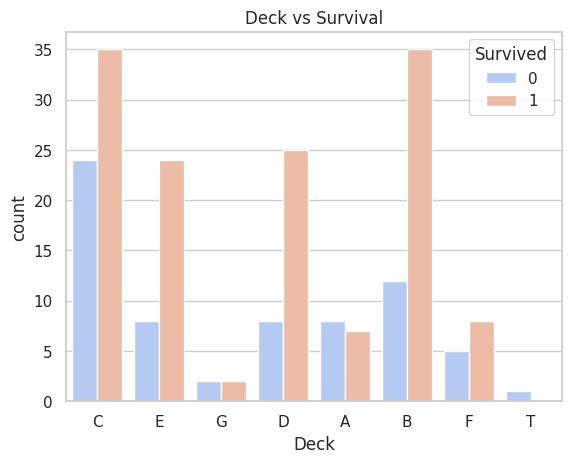

In [1153]:
sns.countplot(x='Deck', hue='Survived', data=df, palette='coolwarm')
plt.title('Deck vs Survival')
plt.show()

### Features to Drop

After creating additional features, we can drop (remove) the features we will never use. Since we inferred from Name and Cabin we can drop them. We can also drop SibSp and Parch but we keep them for now. Ticket is also not very helpful and we don't see any features than can be extracted from it.

In [1154]:
# List columns we won't feed directly (we will drop these later)
cols_to_drop = ['Name', 'Cabin', 'Ticket']

## Preprocessing

*2. Identify missing values and perform appropriate imputation.*

We identified age, embarked, and deck as the features with missing values. We impute them with appropriate techniques later in the preprocessing pipeline.

In [1155]:
missing = df.drop(columns=cols_to_drop).isnull().sum()
missing[missing > 0]

Age         177
Embarked      2
Deck        687
dtype: int64

*4. Convert categorical variables using Label Encoding (ordinal) or One-Hot Encoding
(nominal).*

We identified Pclass as the ordinal feature, while sex, embarked, deck, are nominal. These features will be encoded with ordinal and one-hot encoding, respectively, later in the preprocessing pipline.

In [1156]:
df.drop(columns=cols_to_drop).columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Title', 'FamilySize', 'IsAlone', 'Deck'],
      dtype='object')

Separate the features above into types: numeric, ordinal, nominal, so we can apply appropriate preprocessing techniques to each type.

In [1157]:
num_features = ['Age', 'Fare', 'FamilySize', 'SibSp', 'Parch']
ord_features = ['Pclass']
nom_features = ['Sex', 'Deck', 'Embarked', 'Title', 'IsAlone']

In [1158]:
# Transformations for each column type
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # Replace missing values with median
    ('scaler', StandardScaler()) # Scale numeric data to have mean 0 and variance 1
])

ord_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), # Replace missing values with most frequent
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)) # Encode ordinal data
])

nom_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')), # Replace missing values with constant
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first')) # Encode nominal data with one-hot encoding
])

In [1159]:
# Full preprocessor
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('ord', ord_transformer, ord_features),
    ('nom', nom_transformer, nom_features),
])

# Test preprocessor if it works as expected
preprocessed = preprocessor.fit_transform(df.drop(['Survived'] + cols_to_drop, axis=1))
pd.DataFrame(preprocessed, columns=preprocessor.get_feature_names_out()).head()

,num__Age,num__Fare,num__FamilySize,num__SibSp,num__Parch,ord__Pclass,nom__Sex_male,nom__Deck_B,nom__Deck_C,nom__Deck_D,...,nom__Deck_Missing,nom__Deck_T,nom__Embarked_Missing,nom__Embarked_Q,nom__Embarked_S,nom__Title_Miss,nom__Title_Mr,nom__Title_Mrs,nom__Title_Rare,nom__IsAlone_1
0,-0.565736,-0.502445,0.059160,0.432793,-0.473674,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.663861,0.786845,0.059160,0.432793,-0.473674,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.258337,-0.488854,-0.560975,-0.474545,-0.473674,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0.433312,0.420730,0.059160,0.432793,-0.473674,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.433312,-0.486337,-0.560975,-0.474545,-0.473674,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


## Train-Test Split

*5. Split the dataset into train and test sets.*

In [1160]:
# Prepare X (features) and y (target) data
X = df.drop(['Survived'] + cols_to_drop, axis=1)
y = df['Survived']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, # set the test size to 20%
    random_state=42, # make sure the split is reproducible
)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (712, 11)
X_test shape: (179, 11)


## Model Training

*6. Train at least two classification models. You may use other models in scikit-learn.*

*7. Describe how the models work.*

We selected **Logistic Regression** and **Random Forest** because they offer complementary strengths for this classification task. Logistic Regression is simple and interpretable, providing insight into how each factor contributes to the likelihood of survival. Random Forest, on the other hand, can capture complex patterns and interactions that may not be obvious, offering flexibility and robustness.


### Logistic Regression

Logistic Regression predicts the probability of survival by applying a logistic function to a weighted sum of the input features. It produces a value between 0 and 1, interpreted as the likelihood of survival, and uses a threshold to make the final classification. Its strength lies in its simplicity and interpretability.

In [1161]:
lr_model = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=10000, solver='saga'))
])
lr_model.fit(X_train, y_train)

lr_model.score(X_test, y_test)

0.8100558659217877

### Random Forest Classifier 

Random Forest constructs an ensemble of decision trees, each trained on a random subset of the data and features. The final prediction is based on the majority vote across all trees. This approach allows it to model complex relationships and interactions automatically, while being less sensitive to missing values and outliers.

In [1162]:
rf_model = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])
rf_model.fit(X_train, y_train)

rf_model.score(X_test, y_test)

0.8156424581005587

## Hyperparameter Tuning

To potentially improve the performance, we can tune key hyperparameters of the models using **cross-validation**. This allows the model to find the best combination of parameters for accuracy and generalization.

In [1163]:
# Define the hyperparameter search space
lr_param_distributions = {
    'clf__C': [0.01, 0.1, 1, 10, 100],          # Regularization strength
    'clf__penalty': ['l1', 'l2', 'elasticnet'], # Type of regularization
}

# Stratified K-Fold to maintain class balance
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up cross-validation
lr_random_search = RandomizedSearchCV(
    estimator=lr_model,
    param_distributions=lr_param_distributions,
    n_iter=25,
    cv=cv_strategy,
    scoring='f1', # Optimize for F1 score
    random_state=42,
    n_jobs=-1,
    verbose=0,
)

# Run the search on training data
lr_random_search.fit(X_train, y_train)

# Get best hyperparameters and the tuned model
print("Best Logistic Regression Hyperparameters:", lr_random_search.best_params_)
best_lr_model = lr_random_search.best_estimator_
print("Best F1 score:", lr_random_search.best_score_)

/home/andrianllmm/dev/extracurricular/updssoc/ds100/ds100-ws2/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
25 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/home/andrianllmm/dev/extracurricular/updssoc/ds100/ds100-ws2/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/andrianllmm/dev/extracurricular/updssoc/ds100/ds100-ws2/venv/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
          

Best Logistic Regression Hyperparameters: {'clf__penalty': 'l1', 'clf__C': 10}
Best F1 score: 0.782159226622742


In [1164]:
# Define an expanded search space
rf_param_distributions = {
    'clf__n_estimators': [200, 500, 800, 1000],      # Number of trees
    'clf__max_depth': [None, 5, 10, 15, 20],         # How deep a tree can grow
    'clf__min_samples_split': [2, 5, 10, 15],        # How easily nodes split
    'clf__min_samples_leaf': [1, 2, 4, 6, 8],        # How many samples per leaf
    'clf__max_features': ['sqrt', 'log2', 0.5, None] # How many features to consider
}

# Stratified K-Fold to maintain class balance
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up cross-validation
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_distributions,
    n_iter=50,
    cv=cv_strategy,
    scoring='f1', # Optimize for F1 score
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# Run the search on training data
rf_random_search.fit(X_train, y_train)

# Get best hyperparameters and the tuned model
print("Best Hyperparameters:", rf_random_search.best_params_)
best_rf_model = rf_random_search.best_estimator_
print("Best F1 score:", rf_random_search.best_score_)

Best Hyperparameters: {'clf__n_estimators': 200, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 1, 'clf__max_features': 'sqrt', 'clf__max_depth': 15}
Best F1 score: 0.7715268545604005


## Model Evaluation

*8. Evaluate the models using accuracy, precision, recall, F1 score, and a confusion matrix.*

*9. Create at least one visualization: a confusion matrix heatmap or ROC curve.*

In [1165]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1 Score: {f1:.3f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.show()

### Performance of Default Models

Logistic Regression
Accuracy: 0.810, Precision: 0.770, Recall: 0.770, F1 Score: 0.770


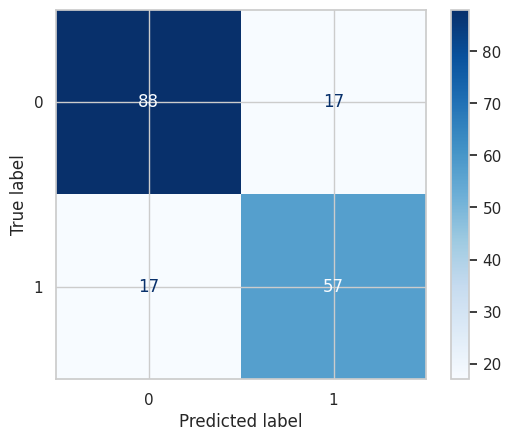

In [1166]:
print("Logistic Regression")
evaluate_model(lr_model, X_test, y_test)

Random Forest Classifier (Default Parameters)
Accuracy: 0.816, Precision: 0.781, Recall: 0.770, F1 Score: 0.776


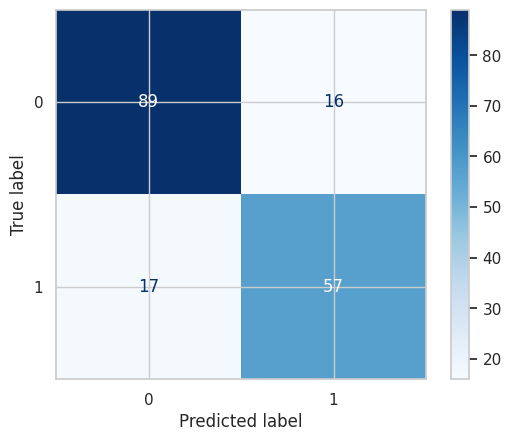

In [1167]:
print("Random Forest Classifier (Default Parameters)")
evaluate_model(rf_model, X_test, y_test)

### Performance After Hyperparameter Tuning

Best Logistic Regression Model (from CV)
Accuracy: 0.821, Precision: 0.784, Recall: 0.784, F1 Score: 0.784


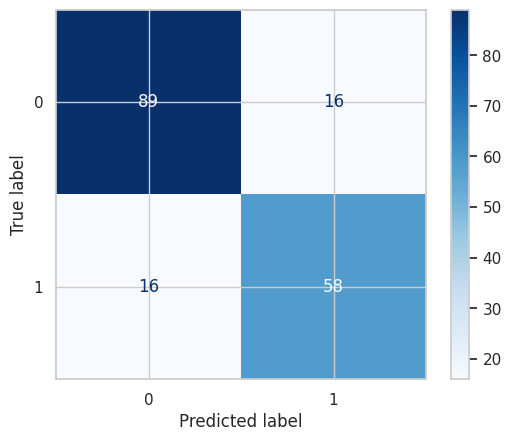

In [1168]:
print("Best Logistic Regression Model (from CV)")
evaluate_model(best_lr_model, X_test, y_test)

Best Random Forest Classifier (from CV)
Accuracy: 0.844, Precision: 0.829, Recall: 0.784, F1 Score: 0.806


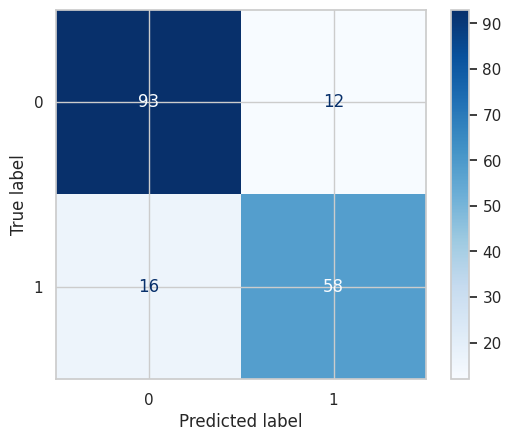

In [1169]:
print("Best Random Forest Classifier (from CV)")
evaluate_model(best_rf_model, X_test, y_test)

*10. Compare model performances and comment on which model performs better and
why.*

### Assessing Performance

Hyperparameter tuning improved both models. Logistic Regression shows a slight boost in accuracy and F1 score, capturing subtle patterns better. Random Forest benefits more noticeably: precision increases while recall stays strong, giving a higher F1 score overall.

After tuning, Random Forest performs slightly better overall because it captures non-linear feature interactions. Logistic Regression remains competitive, balancing precision and recall and offering easier interpretability. Both models handle the dataset well, but Random Forest has the edge in predictive performance.

Random Forest outperformed Logistic Regression because it can capture non-linear relationships and interactions between features (like how class and sex together affect survival), which Logistic Regression cannot. Its ensemble of decision trees models complex patterns, allowing it to better generalize and achieve slightly higher accuracy and F1 score. 

Overall, our best model achieves an accuracy of about **84%**, which means it correctly predicts survival for roughly 8 out of 10 passengers. This is a solid result for this dataset, showing the model captures most patterns, though there is still some room to improve recall for the minority class (survivors).

## Insights

*11. Write 3-5 insights based on your analysis.*

1. **Demographic factors strongly influence survival.** Features like sex, age, and title were highly predictive. Females and younger passengers had higher survival odds, while titles like "Mr." captured additional context.  

2. **Socioeconomic factors matter.** Passenger class and fare significantly affected survival, with wealthier passengers and those in higher classes generally having better access to lifeboats and safer cabins.  

3. **Feature engineering adds value.** Transforming raw data into meaningful features, such as extracting titles from names, creating better family-related indicators, or generalizing specific cabin numbers, improved predictive power.  

4. **Hyperparameter tuning improves model performance.** Careful tuning of models enhanced accuracy and F1 scores, which shows how important it is to choose the right hyperparameters.

5. **Random Forest slightly outperforms Logistic Regression.** Its ability to capture non-linear interactions gives it a modest edge, though Logistic Regression still remains interpretable and competitive.

## Reflection on Feature Importance

*12. Reflect on which features are most predictive of survival and why.*

We can see the importance of the features by inspecting our best model's (Tuned Random Forest) `feature_importances_` attribute.

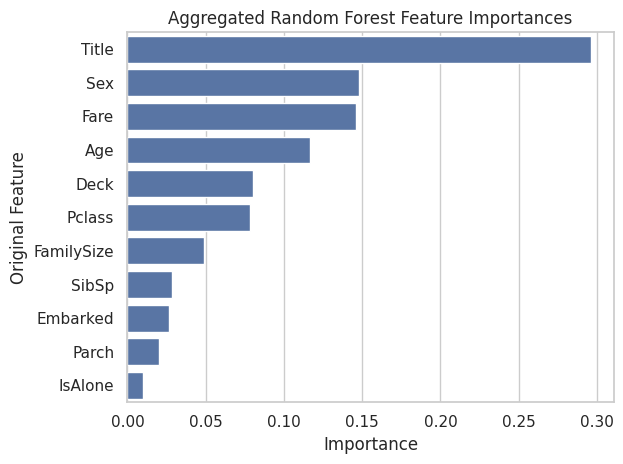

Importance
Original_Feature Feature                     
Title            Title_Rare          0.007978
                 Title_Mrs           0.061060
                 Title_Mr            0.189978
                 Title_Miss          0.037110
SibSp            SibSp               0.028375
Sex              Sex_male            0.148177
Pclass           Pclass              0.078168
Parch            Parch               0.020391
IsAlone          IsAlone_1           0.009990
Fare             Fare                0.146094
FamilySize       FamilySize          0.048793
Embarked         Embarked_S          0.018888
                 Embarked_Q          0.007799
                 Embarked_Missing    0.000092
Deck             Deck_T              0.000296
                 Deck_Missing        0.041143
                 Deck_G              0.001835
                 Deck_F              0.001784
                 Deck_E              0.011566
                 Deck_D              0.006386
                 Deck_C              0.007639
                 Deck_B              0.009850
Age              Age                 0.116606

In [1170]:
# Extract Random Forest and preprocessor
rf_clf = best_rf_model.named_steps['clf']
preprocessor = best_rf_model.named_steps['pre']

# Get feature names
num_features = preprocessor.transformers_[0][2]
ord_features = preprocessor.transformers_[1][2]
nom_features = preprocessor.named_transformers_['nom'].named_steps['onehot'].get_feature_names_out(preprocessor.transformers_[2][2])
feature_names = np.concatenate([num_features, ord_features, nom_features])

# Create DataFrame with importances
feat_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_clf.feature_importances_
})
feat_importances['Original_Feature'] = feat_importances['Feature'].str.split('_').str[0]
feat_importances = feat_importances.set_index(['Original_Feature', 'Feature'])
feat_importances.sort_index(ascending=False, inplace=True)

# Plot feature importances
plot_df = feat_importances.groupby('Original_Feature')['Importance'].sum().sort_values(ascending=False).reset_index()
plot_df.columns = ['Original_Feature', 'Importance']

sns.barplot(
    data=plot_df,
    x='Importance',
    y='Original_Feature',
)
plt.title('Aggregated Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Original Feature')
plt.tight_layout()
plt.show()

display(feat_importances)

The model highlights several features as key drivers of survival predictions:  

- **Sex** stands out as the most influential predictor. Being male strongly decreases survival likelihood, while being female greatly increases it.  
- **Title** provides important social and demographic context. Certain titles associated with adults or high social status tend to increase survival probability, while others, like generic male titles, decrease it. This is consistent with the Sex feature since they are somewhat parallel.
- **Age** plays a significant role. Younger passengers, especially children, tended to survive at higher rates, consistent with “women and children first” policies.  
- **Class and Fare**, such as passenger class and fare, are highly informative. Higher-class passengers and those who paid higher fares had noticeably better chances of survival, reflecting both social standing and proximity to lifeboats.  
- **Family Relations**, such as siblings and parents, have moderate influence. Small family groups generally saw higher survival rates, while passengers traveling alone had lower odds.  
- Features like **Deck** and **Embarked** contribute little to the model’s predictions, likely due to incomplete data, uneven distribution across categories.

Overall, the model confirms that **demographics** and **socioeconomic factors** as we've discussed earlier from the analysis.

# Finishing Up

To finish up, we can export our model to a `.pkl` file. This is a file that can be read by other Python programs.

In [1171]:
# Save the model to a file
joblib.dump(best_rf_model, '../models/model.pkl')

# To load it later
loaded_model = joblib.load('../models/model.pkl')

We can now share this model to the world :)